In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")


path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    # "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))

path_pipeline = path_git.joinpath("sisepuede_data_pipeline")


import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as svp
import sisepuede.utilities._plotting as spu
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import time

from sisepuede.core.attribute_table import *
from typing import *


import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil




In [363]:
### SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")
path_attr_tp = path_transformations.joinpath("attribute_dim_time_period.csv")


##  SETUP FILES




##  SETUP SOME PIPELINE STUFF

# get the time period
attr_time_period = AttributeTable(path_attr_tp, "time_period")
file_struct = sfs.SISEPUEDEFileStructure(
    attribute_time_period = attr_time_period,
)

# assign some shortcuts
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)


##  SOME GLOBALS

_REGION_NAME = "libya"#"morocco"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )

path_data_built = pathlib.Path(
    os.path.abspath(f"../generic_regions/data/output/sisepuede_raw_inputs_latest_{_REGION_ISO}.csv")
)

In [78]:
models = sm.SISEPUEDEModels(
    matt, 
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)

In [364]:
df_morocco = pd.read_csv(path_data_built, )
df_morocco[regions.key] = _REGION_NAME


In [368]:
import sisepuede.transformers as trf
import sisepuede.transformers.transformations as tmts
importlib.reload(tmts.trs.tbe)
importlib.reload(tmts.trs)

# initialize a transformations set
if not path_transformations.is_dir():
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )




transformations = tmts.Transformations(
    path_transformations,
    attr_time_period = attr_time_period,
    df_input = df_morocco,
)
transformers = transformations.transformers

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)







In [96]:
strat0 = strategies.get_strategy(0)
df0 = strat0()

df_out = models(
    df0, 
    include_electricity_in_energy = True, 
    time_periods_base = range(11),
)

2025-03-Nov 20:25:11.993 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/morocco/tmp0ndssv7r.sqlite.
2025-03-Nov 20:25:12.002 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/morocco/tmp0ndssv7r.sqlite.
2025-03-Nov 20:25:12.792 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-03-Nov 20:25:12.836 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 20:25:22.414 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [ ]:
df_out = models(
    strategies.get_strategy(0)(), 
    include_electricity_in_energy = False, 
)

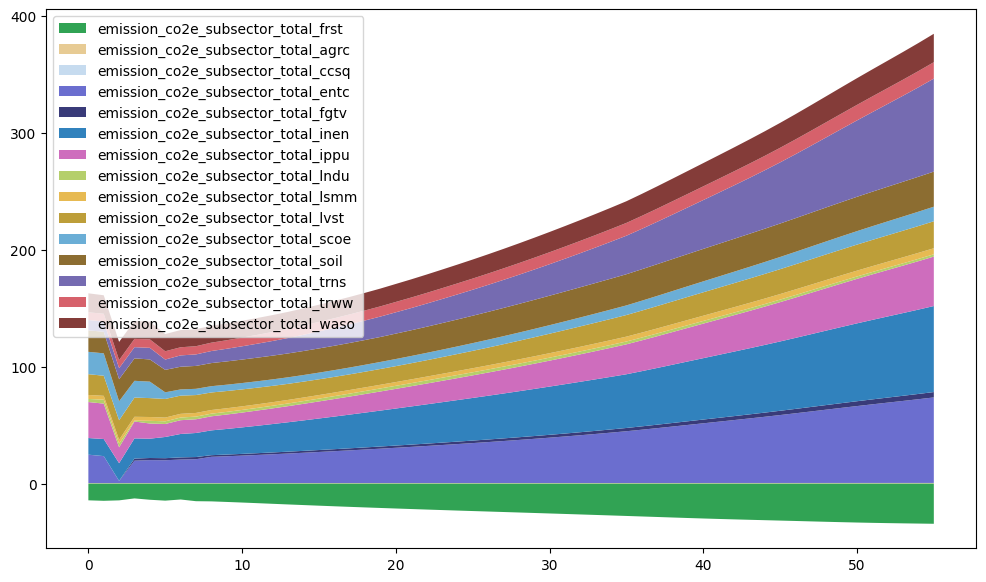

In [70]:
fig, ax = plt.subplots(figsize = (12, 7))
svp.plot_emissions_stack(df_out, matt, figtuple = (fig, ax, ))
ax.legend()